In [1]:
#connect google colab with google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.linear_model import LogisticRegression

In [6]:
# load the three models
model1 = load_model('/content/gdrive/MyDrive/MajorProject/br35hdataset/cnn-softmax-adam.h5')
model2 = load_model('/content/gdrive/MyDrive/MajorProject/br35hdataset/inception-cnn.h5')
model3 = load_model('/content/gdrive/MyDrive/MajorProject/br35hdataset/imagepreprocess_cnn.h5')


In [7]:
# Load the validation data
val_dir = '/content/gdrive/MyDrive/MajorProject/br35hdataset/validation/'
val_data = []
val_labels = []

In [12]:
# Make predictions using model1
model1_predictions = []
for label in ['yes', 'no']:
    label_dir = os.path.join(val_dir, label)
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        if len(model1.layers) > 0 and len(model1.layers[0].input_shape) > 1 and model1.layers[0].input_shape[1] == 256:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
            image = cv2.merge([image, image, image])  # Add 2 more channels to match the input shape of model1
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            prediction = model1.predict(image)
            model1_predictions.append(prediction[0])


1/1 [==============================] - 0s 55ms/step


In [13]:
# Make predictions using model2
model2_predictions = []
for label in ['yes', 'no']:
    label_dir = os.path.join(val_dir, label)
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (299, 299), interpolation=cv2.INTER_CUBIC)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        prediction = model2.predict(image)
        model2_predictions.append(prediction[0])


1/1 [==============================] - 0s 261ms/step


In [14]:
# Make predictions using model3
model3_predictions = []
for label in ['yes', 'no']:
    label_dir = os.path.join(val_dir, label)
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        if len(model3.layers) > 0 and len(model3.layers[0].input_shape) > 1 and model3.layers[0].input_shape[1] == 256:
            image = cv2.imread(image_path)
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert image to RGB
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            prediction = model3.predict(image)
            model3_predictions.append(prediction[0])


1/1 [==============================] - 0s 66ms/step


In [20]:
# Combine predictions from all models
stacked_predictions = np.column_stack((model1_predictions, model2_predictions, model3_predictions))

In [21]:
# Load the validation labels
y = []
for label in ['yes', 'no']:
    label_dir = os.path.join(val_dir, label)
    for image_file in os.listdir(label_dir):
        y.append(1 if label == 'yes' else 0)

In [22]:
# Train the meta-model on the stacked predictions and validation labels
metamodel = LogisticRegression()
metamodel.fit(stacked_predictions, y)

LogisticRegression()

In [23]:
# Use the trained meta-model to make final predictions
final_predictions = metamodel.predict(stacked_predictions)

In [24]:
# Save the trained meta-model
from sklearn.linear_model import LogisticRegression
from joblib import dump

# Save the trained model
dump(metamodel, '/content/gdrive/MyDrive/MajorProject/br35hdataset/model.joblib')


['/content/gdrive/MyDrive/MajorProject/br35hdataset/model.joblib']

In [25]:
from joblib import load

# Load the saved metamodel
metamodel = load('/content/gdrive/MyDrive/MajorProject/br35hdataset/model.joblib')


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y, final_predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y, final_predictions)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y, final_predictions)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y, final_predictions)
print("F1-score:", f1)

# Calculate F-beta score
fbeta = fbeta_score(y, final_predictions, beta=0.5)
print("Fbeta-score:", fbeta)

# Calculate sensitivity (true positive rate)
sensitivity = recall
print("Sensitivity:", sensitivity)

# Calculate specificity (true negative rate)
tn, fp, fn, tp = confusion_matrix(y, final_predictions).ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, final_predictions)
print("Confusion matrix:\n", conf_matrix)


Accuracy: 0.9638888888888889
Precision: 0.9531416400425985
Recall: 0.9770742358078602
F1-score: 0.9649595687331536
Fbeta-score: 0.9578339041095891
Sensitivity: 0.9770742358078602
Specificity: 0.9502262443438914
Confusion matrix:
 [[840  44]
 [ 21 895]]


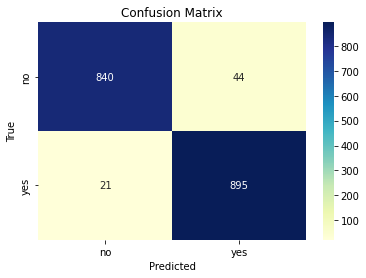

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the validation labels
y_true = []
for label in ['yes', 'no']:
    label_dir = os.path.join(val_dir, label)
    for image_file in os.listdir(label_dir):
        y_true.append(1 if label == 'yes' else 0)

# Use the trained meta-model to make final predictions
y_pred = metamodel.predict(stacked_predictions)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['no', 'yes']

# Create a heatmap from the confusion matrix
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)

# Add axis labels and a title
heatmap.set_xlabel('Predicted')
heatmap.set_ylabel('True')
heatmap.set_title('Confusion Matrix')

# Show the plot
plt.show()
